# Classification task: Non-LM approach

In [26]:
from datasets import load_dataset
import pandas as pd
from tqdm.notebook import tqdm
import numpy as np
import time
from sklearn.decomposition import PCA
import requests
import matplotlib.pyplot as plt
from collections import Counter
from concurrent.futures import ThreadPoolExecutor,ProcessPoolExecutor,as_completed
from scipy.spatial.distance import euclidean
from statistics import mean, stdev
from sklearn.feature_extraction.text import TfidfTransformer
from collections import defaultdict
import json
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay,f1_score

## Load Dataset(training and Validation)

In [27]:
ds=load_dataset("sapienzanlp/nlp2025_hw1_cultural_dataset") #load dataset from Hugging face

train_set=pd.DataFrame(ds["train"]) #take train_set and treat it as dataframe
X_train=train_set.values #take dataset in matrix shape

validation_set=pd.DataFrame(ds["validation"]) #take validation set and treat it as dataframe
X_valid=validation_set.values

# Training phase
## Step 1: Building a Vocabulary with the most important properties of training items
---
### Function manipulates url of entity item and samples associated to classes

In [28]:
#function which extracts wiki-item Qxxx 
def extract_entity_id(url): 
    return url.strip().split("/")[-1] 
#extract all samples from that class 
def extract_sample_from_class(X,label):
    l=list()
    for elem in X:
        if elem[6]==label:
            l.append(elem[0])
    return l

### Function for bulding vocabulary of properties

In [29]:
# Function to get request in a more efficient way without 1 to 1 corresponding request
def handle_get_request(entities_list,labeled):
        batch_size=40 # number of entity from extraction 
        url_base = "https://www.wikidata.org/w/api.php" # url base to peform a HTTP request to obtain Wikidata properties using api
        results = {} # dictionary  where entity |Qxxx| are the keys while the claims will be the corresponding values
        total_batches = (len(entities_list) + batch_size - 1) // batch_size # compute how many subsets of extraction 

        with tqdm(total=total_batches, desc=f"Downloading batch of class {labeled}") as pbar:
            for i in range(0, len(entities_list), batch_size): # loop for every batch of all entities

                batch = entities_list[i:i + batch_size] # i-th batch
                ids_string = "|".join(batch) # Considers a sequence of |Q1xxx|Q2xxx| items to collect from the server
                
                # define parameters of get request
                params = { 
                    "action": "wbgetentities", # obtain wbentities
                    "ids": ids_string, # specify which items we want to extract corresponding to the i-th batch
                    "format": "json"
                }

                attempt=0 # number of attempt in case of errors
                success=False

                while not success and attempt <3:

                    try:

                        response_get_id = requests.get(url_base, params=params, timeout=20) # it obtains a get of properties using previous parameters  
                        response_get_id.raise_for_status() # verify if the HTTP request fails and eventually store the error in e 
                        data = response_get_id.json() # extract data from json file

                        entities = data.get("entities", {}) # extract all properties of every item
                        for entity_id, entity_data in entities.items():  
                            claims = entity_data.get("claims", {}) # obtain claims
                            results[entity_id] = claims # collect all claims of an item |Qxxx| in a dictionary 
                        
                        success=True
                    except requests.exceptions.RequestException as e: 

                        print(f"Batch Error {batch}: {e}", flush=True)
                        wait_time = 2 ** attempt  # we increase time with exponential control wrt the number of attempts
                        
                        print(f"Retry waiting  {wait_time}s...", flush=True)
                        time.sleep(wait_time) # introduce a little execution delay to retry the same HTTP Request
                        attempt+=1
                pbar.update(1)
            return results
        
# extraction of identities from samples belonging to the same class 
def extraction_identities_from_sample(X,C=None):
    list_identities=[]
    list_sample_cat=[]

    # we detect 3 cases: 
    if type(C)==str: # case of explicit expression of a class :'cultural agnostic','cultural representative','cultural exclusive
        
        list_sample_cat=extract_sample_from_class(X,C) # extract all items from dataset belonging to class C

    elif C!=None: # case of giving a list of categories

        for elem in C:
            list_sample_cat.extend(extract_sample_from_class(X,elem)) # we collect all url items 
    
    else: # case of extraction of all samples without a specific category
        
        list_sample_cat=X[:,0]
        
    set_properties=list()

    for url in list_sample_cat:

        entity_train=extract_entity_id(url) # extract only the last part of url Qxxxx

        if entity_train.startswith("Q"): # verify if entity_id starts with Q
            list_identities.append(entity_train)

    claims_identity=handle_get_request(list_identities,C) # recall the function obtaining a dictionary of all properties associated to all selected items in list identities
    

    for entity_id, claims in claims_identity.items(): # take all claims from all entities

        set_property_item=set()

        for prop_id in claims.keys(): # take all properties Pxx from claims associated to each entitity
            set_property_item.add(str(prop_id)) # create set of properties for that item 

        set_properties.append(set_property_item) # create a list of properties sets
    return set_properties

vocabulary=list()

# build a vocabulary of selected properties with a statistical approach
def build_vocabulary(classes):
    vocabulary_subset=list()
    
    set_properties=list()
   
    set_properties=extraction_identities_from_sample(X_train,classes) #collect all properties of sample belonging to the same class

    property_presence_sample=defaultdict(list) # dictionary contains as a key a property belonging to a set_properties, and as a value a list 1/0 if it is in a set of corresponding properties of each sample
    all_props = set().union(*set_properties)  # collect all properties of all samples
    
    for prop in all_props:
        for prop_set in set_properties:
            # append 1 if prop belongs into prop_set 
            property_presence_sample[prop].append(1 if prop in prop_set else 0)
    
    filtered_props = [] # a list of tuples (prop,prop_mean,prop_std)

    for prop, values in property_presence_sample.items(): # for every prop takes a list of 1/0
        prop_mean = mean(values) # compute the mean of that property in a set of samples 
        if len(values) > 1:
            prop_std = stdev(values)  # compute the standard deviation of that property in a set of samples
        else:
            prop_std=0
        filtered_props.append((prop, prop_mean, prop_std)) # collection of tuples with all statistical measures of each prop
   
    counter=Counter()
    for s in set_properties: # for every property in the properties set, update for each sample the number of occurrencies of each property 
        counter.update(s)
       
    z_th=0
    z_scores=[] # list of all zscore
    valid_props=[] # properties with dev_std>0
    
    for prop_id,mu_prop,dev_s_prop in filtered_props:
       
        if dev_s_prop>0:
            z_score=(counter.get(prop_id)-mu_prop)/dev_s_prop # apply zscore to analyze a score to distinguish more/less important properties
            z_scores.append(z_score) # collect a z_score of every propery
            valid_props.append(prop_id) # collect a valid prop_id 
    
    # choose z_th threshold
    if z_scores:
        z_th=np.percentile(z_scores,60) # choose a percentile strategy to set a scalar value at 60 percentile as a threshold
    else:
        z_th=0 
               
    for prop_id,z in zip(valid_props,z_scores):
        
        if z>=z_th: # for every z_score of valid prop, if it overcomes the 60 percentile then it will be added to a vocabulary
            vocabulary_subset.append(prop_id)    

    return vocabulary_subset

### Extract the most frequent properties observing sample for every feature category

In [30]:
# We use a thread approach to parallelize the extraction of properties for categories
list_class=["cultural agnostic","cultural representative","cultural exclusive"]
set_properties_all_sample=dict()

with  ThreadPoolExecutor(max_workers=3) as executor:
    results={executor.submit(build_vocabulary,category): category for category in list_class} # every thread executes the build_vocabulary function with one category belonging to list_category
    
    progress_bar = tqdm(total=len(results), desc=f"Building vocabulary") # bar to visualize the progress of threads

    for vocab in as_completed(results): # when the result of any thread is ready it will be added to the vocabulary
        try:
            
            vocab_subset= vocab.result() # extract the result of a thread
            vocabulary.extend(vocab_subset) # vocabulary is extended with the thread result
        except Exception as e:
            print(f"Error in extraction property for label {results[vocab]}: {e}") # 
        finally:
            progress_bar.update(1)   
    progress_bar.close()

vocabulary=list(set(vocabulary)) # take all properties before building the vocabulary set to eliminate all duplicates of same properties
print("Updated Vocabulary: for categories",vocabulary)
with open("vocabulary_category.json", "w") as f: # open in write mode the file "vocabulary_category.json" and write the vocabulary of properties
    json.dump(vocabulary, f)

Building vocabulary:   0%|          | 0/3 [00:00<?, ?it/s]

Updated Vocabulary: for categories ['P527', 'P7745', 'P3311', 'P7986', 'P9522', 'P9178', 'P7695', 'P272', 'P7937', 'P1301', 'P3402', 'P437', 'P1417', 'P8349', 'P11693', 'P13227', 'P2974', 'P2795', 'P8130', 'P360', 'P5641', 'P149', 'P974', 'P1308', 'P605', 'P8977', 'P5421', 'P5263', 'P7574', 'P3204', 'P5489', 'P1952', 'P1442', 'P740', 'P10376', 'P2950', 'P4459', 'P9563', 'P5356', 'P5909', 'P243', 'P347', 'P6379', 'P8072', 'P350', 'P10883', 'P512', 'P1257', 'P7212', 'P7066', 'P2061', 'P4682', 'P735', 'P10925', 'P5432', 'P3212', 'P990', 'P2001', 'P1335', 'P7561', 'P2167', 'P7842', 'P11327', 'P409', 'P5586', 'P5337', 'P2579', 'P2465', 'P7775', 'P8540', 'P3151', 'P5055', 'P509', 'P1042', 'P7003', 'P4529', 'P3913', 'P13390', 'P8324', 'P10234', 'P4212', 'P5082', 'P7193', 'P1580', 'P2949', 'P10527', 'P57', 'P194', 'P3241', 'P2789', 'P937', 'P2342', 'P8406', 'P7854', 'P162', 'P3761', 'P345', 'P421', 'P2572', 'P6849', 'P840', 'P4025', 'P7214', 'P3362', 'P1241', 'P5184', 'P1015', 'P10524', 'P575'

## Step 1: Embedding in binary vectors 
--- 

### Functions to compute **weigths distance estimation and embedding sample**

In [31]:
# compute the weight of a sample based on its distance from a centroid X2 (less distance->higher weights)
def weight_distance_estimation(X1,X2):
   
    dist=euclidean(X1,X2) # computes euclidean distance
    
    weights=np.exp(-dist) # inverse of distance using an exponential trend for more robustness of weight values
    
    return weights

# function for sample embedding with one-hot-encoding methodology if sample X has property Pxxx   
def embedding_sample(X_data,vocabulary,sample_properties=None):
    
    def process_sample(X,vocab,set_p=None):
        set_prop=extraction_identities_from_sample(X) # for every sample extract all identities
        sample=np.zeros((X.shape[0],len(vocab)),dtype=np.int32) # create matrix of x_train_embedded (X_dimension,n_properties of vocabulary)

        for i in range(0,len(set_prop)):
            for v in range(0,len(vocab)):
                if vocab[v] in set_prop[i]: # if property v belongs to the set_p of that sample -> sample cell at index v will be 1 
                    sample[i,v]=1 
        return sample
    
    return process_sample(X_data,vocabulary)

### Open saved vocabulary  

In [32]:
with open("vocabulary_category.json","r",encoding="utf-8") as f: # open file vocabulary_category.json in read mode to load the stored vocabulary containing properties
    vocabulary_j=json.load(f) # load vocabulary in json format

### Embedding **Cultural Representative Samples**

In [33]:
print("Embedding cultural representative samples")
# embedding 1/0 values of all cultural representative samples using collected vocabulary 
culture_representative_train=embedding_sample(X_train[X_train[:,6]=='cultural representative'],vocabulary_j) 


Embedding cultural representative samples


### Embedding **Cultural Agnostic samples**

In [34]:
print("Embedding cultural agnostic samples")
# embedding 1/0 values of all cultural agnostic samples using collected vocabulary 
culture_agnostic_train=embedding_sample(X_train[X_train[:,6]=='cultural agnostic'],vocabulary_j)

Embedding cultural agnostic samples


### Embedding **Cultural Exclusive samples**

In [35]:
print("Embedding cultural exclusive samples")
# embedding 1/0 values of all cultural exclusive samples using collected vocabulary 
culture_exclusive_train=embedding_sample(X_train[X_train[:,6]=='cultural exclusive'],vocabulary_j)

Embedding cultural exclusive samples


### Save all result in **train_sample_embeddings.npz**

In [36]:
# save all embedded samples in file "train_sample_embeddings.npz"
np.savez("train_sample_embeddings.npz",representative=culture_representative_train,agnostic=culture_agnostic_train,exclusive=culture_exclusive_train)

### Transform Label **Cultural Agnostic**, **Cultural Representative**, **Cultural Exclusive** into **0,1,2**

In [37]:
# Function which transforms the label Y ["cultural agnostic","cultural representative","cultural exclusive"] into [0,1,2]
def numerical_label(Y):
    Y_index=np.zeros(Y.shape[0],dtype=np.int32)
    for i in range(0,Y.shape[0]):
        if Y[i]=="cultural agnostic":
            Y_index[i]=0
        elif Y[i]=="cultural representative":
            Y_index[i]=1
        else:
            Y_index[i]=2
    return Y_index
# Function which transforms all sample labels==label->1 otherwise 0
def binary_label(Y,label):
    return (Y==label).astype(int)

## Step:2 Compute Centroids and weighted property
---

## Functions to compute best separated centroids

In [38]:
# predict function of every sample
def predict_entity_score(x_sample,centroid_CA,centroid_CR,centroid_CE,T,tfidf):  

    list_sample=[]
    
    # transform every sample associating weights wrt same distribution of train samples methodology
    if T=='test':
        x_sample=tfidf.transform([x_sample]).toarray()[0]
        list_sample.append(x_sample)
    
    # compute the weights of every sample using the euclidean distance wrt specific centroid  
    similiraty_sample_CA=weight_distance_estimation(x_sample,centroid_CA) 
    similarity_sample_CR=weight_distance_estimation(x_sample,centroid_CR)
    similarity_sample_CE=weight_distance_estimation(x_sample,centroid_CE)
 
    # compute the sum of all weights of similarity  
    Sum_weight=similarity_sample_CE+similarity_sample_CR+similiraty_sample_CA

    # normalize wrt this sum to obtain a value among [0,1] to treat as a probability
    total_score_agnostic=similiraty_sample_CA/Sum_weight
    total_score_exclusive=similarity_sample_CE/Sum_weight
    total_score_representative=similarity_sample_CR/Sum_weight
    
    # build a vector with the following values and compute the argmax
    v=[total_score_agnostic,total_score_representative,total_score_exclusive]
    class_pred=np.argmax(v)
    if T=='test':
        return class_pred,list_sample
    return class_pred

In [39]:
from itertools import product
# build a vector embedding 
def building_vector_embedding(X):
  tfidf_prop= TfidfTransformer(norm='l2', use_idf=True, smooth_idf=True) # we use a L2 normalization to transform the input 1/0 in weigthed values
  X_train_weight_prop= tfidf_prop.fit_transform(X).toarray() # fit and transform X into X_train_weight where every sample will have a weight wrt the importance of a property
  
  return X_train_weight_prop,tfidf_prop

# generate centroids
def generate_centroids(X,Y,alpha_dict):
  classes=["cultural agnostic","cultural representative","cultural exclusive"] 
  class_means={}

  for c in classes:
    sample_classes = (Y == c)
    class_means[c] = np.mean(X[sample_classes], axis=0) # compute the centroid for every class c considering all samples corresponding to c

  # compute the balanced mean among the 3 centroids 
  mu_balanced = np.mean(np.stack([class_means[classes[0]],class_means[classes[1]],class_means[classes[2]]]), axis=0)

  centroid_=[]

  for c in classes:
    # separate every centroid with same mu_balanced value weighted with a different scalar associated to each centroid  
    centroid=class_means[c]+alpha_dict[c]*(class_means[c]-mu_balanced) 
    centroid_.append(centroid)

  return centroid_

def fine_tuning_alpha_disp_centroid(param):
  # collect all parameters to find the best combination of weighted separation of centroids
  a_agn, a_rep, a_exc,X,Y,tf=param
  centroids=None

  # build a dictionary with that combination of weighted scalar values
  alpha_dict ={
        "cultural agnostic": a_agn,
        "cultural representative": a_rep,
        "cultural exclusive": a_exc
  }

  centroids = generate_centroids(X,Y, alpha_dict) # generate some possible separated centroids 

  y_pred=[]
  for i in range(0,X.shape[0]):
    # compute the prediction of every training sample to find the best fine tuning
    y=predict_entity_score(X[i],centroids[0],centroids[1],centroids[2],'train',tfidf=tf) 
    y_pred.append(y) 
  
  y_true =numerical_label(Y) # transform every Y in y_true 

  f1 = f1_score(y_true, y_pred,average='macro') # commpute the F1_score obtained from 3 classes
  
  return (f1, (a_agn, a_rep, a_exc), centroids) 


### Compute weights of embedded sample properties wrt singular label (TF-IDF approach) 

In [40]:
train_embedded=np.load("train_sample_embeddings.npz")

# concatenate all samples 
all_train_sample=np.concatenate((train_embedded["agnostic"],train_embedded["representative"],train_embedded["exclusive"]),axis=0)

# define a vector of labels such that we will have n "cultural agnostic" lines concatenated to m "cultural representative" concatenated to p "cultural exclusive" ones 
y_train=np.array(["cultural agnostic"]*len(train_embedded["agnostic"])+["cultural representative"]*len(train_embedded["representative"])+["cultural exclusive"]*len(train_embedded["exclusive"]))

# associate weights to x_train using TF-IDF approach
X_train_weight,tifdif=building_vector_embedding(all_train_sample)



### Fine-Tuning to compute the best separation of centroids

In [41]:
alpha_values=[0,0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9,1] # define a list of possibile values of alpha
grid = list(product(alpha_values, repeat=3))

best_score=0.50 # best initial score
best_config=None # best config found 
best_centroids=None # best centroids found
tasks = [(a_agn, a_rep, a_exc, X_train_weight, y_train,tifdif) for (a_agn, a_rep, a_exc) in grid] # build all possible combinations of alphas

with ProcessPoolExecutor(max_workers=10) as executor:
      results = {executor.submit(fine_tuning_alpha_disp_centroid, task):task for task in tasks} # run one process for every task combination
      
      progress_bar = tqdm(total=len(results), desc=f"Fine-tuning Alpha")
      
      for r in as_completed(results):
            try:
                
                  f1,config,centroids=r.result() # collect all results into a tuple

                  if f1 > best_score: 

                        best_score = f1 # take the best F1 Score
                        best_config = config  # take the best configuration of alpha 
                        best_centroids=centroids # take the best distanced centroids 

            except Exception as e:
                  print(f"Error during task execution {results[r]}: {e}")

            progress_bar.update(1)

      progress_bar.close()


print(f"best_config {best_config}")

centroid_agnostic=best_centroids[0]
print(f"centroid_agnostic {centroid_agnostic.shape}",centroid_agnostic)
centroid_representative=best_centroids[1]
print(f"centroid_representative {centroid_representative.shape}",centroid_representative)
centroid_exclusive=best_centroids[2]
print(f"centroid_exclusive {centroid_exclusive.shape}",centroid_exclusive)


Fine-tuning Alpha:   0%|          | 0/1331 [00:00<?, ?it/s]

best_config (1, 0.6, 0.4)
centroid_agnostic (1902,) [ 0.01880171 -0.00108768 -0.00012111 ...  0.02758884 -0.00023625
 -0.00039147]
centroid_representative (1902,) [ 2.72156994e-02  4.18741408e-03 -4.06392062e-05 ...  2.05023989e-02
 -1.41750908e-04  1.48580806e-03]
centroid_exclusive (1902,) [ 1.99710010e-02 -1.01838495e-04  1.66163597e-03 ...  2.24060508e-02
  8.97755752e-04 -1.80048638e-05]


### Store centroids and embedded validation samples in corresponding file **centroids_every_label.npz**, **X_valid_embedded.npz**

In [42]:
# save centroids in "centroids_every_label.npz"
np.savez("centroids_every_label.npz",centroid_CA=centroid_agnostic,centroid_CR=centroid_representative,centroid_CE=centroid_exclusive)

# embedding validation with same vocabulary of previous case 
X_valid_embed=embedding_sample(X_valid,vocabulary_j)

# save embedding validation samples in "X_valid_embedded.npz"  
np.savez("X_valid_embedded.npz",validation_embedded=X_valid_embed)

## Testing phase
---

### Loading **train_sample_embedded, centroids, weights_properties, valid_embedded** 

In [43]:
train_embedded=np.load("train_sample_embeddings.npz")
centroids=np.load("centroids_every_label.npz")
valid_embedded=np.load("X_valid_embedded.npz")
X_valid_emb=valid_embedded["validation_embedded"]

### Testing on Validation Set and Plot of Classification Report and Confusion Matrix

classification report:
                          precision    recall  f1-score   support

      cultural agnostic       0.91      0.78      0.84       136
cultural representative       0.55      0.70      0.62        84
     cultural exclusive       0.71      0.68      0.69        80

               accuracy                           0.73       300
              macro avg       0.72      0.72      0.72       300
           weighted avg       0.75      0.73      0.74       300



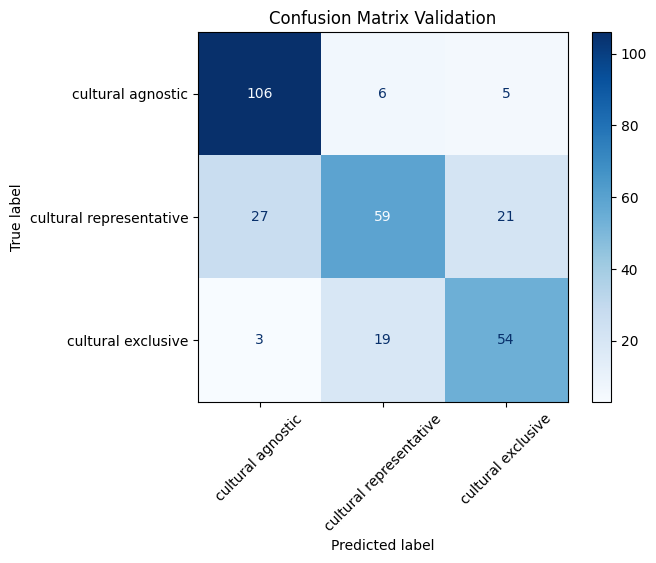

In [44]:
Y_true_valid=numerical_label(X_valid[0:,6]) # transform in numerical labels the validation set 

Y_pred=np.zeros(X_valid_emb.shape[0],dtype=np.int32)
list_x_dev_weight=[]

for i in range(0,X_valid_emb.shape[0]):

    # predict every sample of validation with Centroid CA, Centroid CR, Centroid CE and corresponding property weights wrt CA,CR,CE
    index_class_valid,list_sample_i=predict_entity_score(X_valid_emb[i],centroids["centroid_CA"],centroids["centroid_CR"],centroids["centroid_CE"],'test',tfidf=tifdif)
    
    # collect all y_pred
    Y_pred[i]=index_class_valid 

    # collect all x_test_weigthted 
    list_x_dev_weight.extend(list_sample_i)

labels=["cultural agnostic","cultural representative","cultural exclusive"]

# classification report 
report=classification_report(Y_pred,Y_true_valid, target_names=labels)
print("classification report:\n",report)

# store classification report in file "classification_report_validation.txt"
with open("classification_report_validation.txt", "w") as f:
    f.write(report)


# plot Confusion matrix 
cm_validation=confusion_matrix(Y_true_valid,Y_pred,labels=[0,1,2])
disp_conf_matrix=ConfusionMatrixDisplay(confusion_matrix=cm_validation,display_labels=labels)
disp_conf_matrix.plot(cmap=plt.cm.Blues,xticks_rotation=45)
plt.title("Confusion Matrix Validation")
plt.show()
plt.savefig("confusion_matrix_validation.png")
plt.close()



## Function to save results in **File_output_prediction.csv**

In [45]:
# compute the original label associated to numerical label [0,1,2]
def return_original_label(Y):
    l_pred=[]
    for y in Y:
        if y==0:
            l_pred.append("cultural agnostic")
        elif y==1:
            l_pred.append("cultural representative")
        else:
            l_pred.append("cultural exclusive")
    return l_pred

In [46]:
# save Y prediction on validation set in file_csv
y_pd=pd.DataFrame(np.column_stack((X_valid[:,0],X_valid[:,1],X_valid[:,6],return_original_label(Y_pred))),columns=["item","name","label","predict_label"])
y_pd.to_csv("NON_LM_Approach_output_dev_prediction.csv")

## Plot of dispaced point on X_valid with respect to the centroids

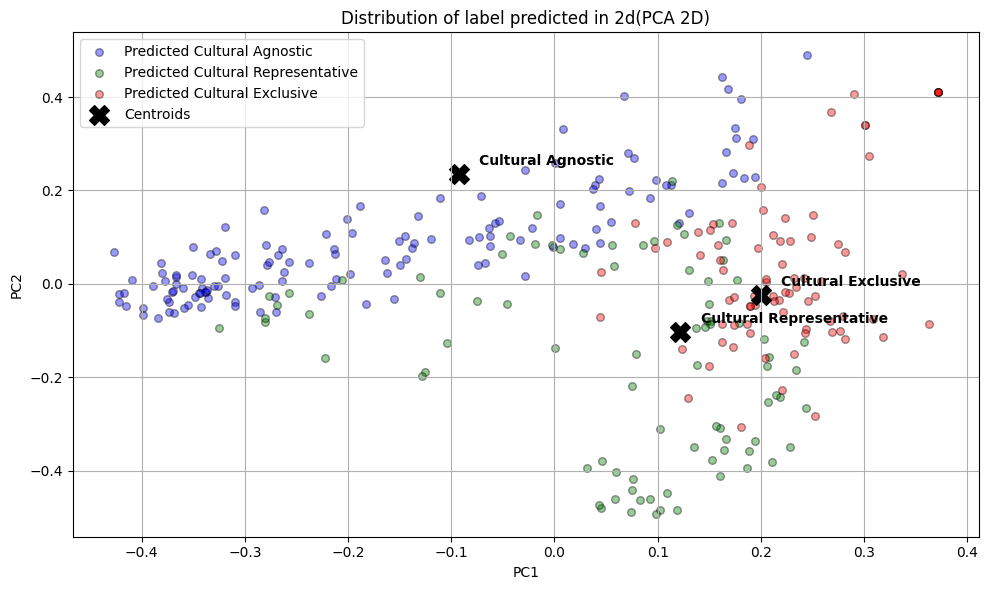

In [47]:
# save in stack all x_test_weighted
def plot_graph_centroid_prediction(list_x_dev_weight,centroids,Y_pred):
    x_test_weight=np.stack(list_x_dev_weight)

# using PCA method project all samples in 2 components
    pca = PCA(n_components=2)
    X_2d = pca.fit_transform(x_test_weight)

# transform also the centroids with the same distribution 
    centroids_2d = pca.transform(np.stack([centroids["centroid_CA"],centroids["centroid_CR"],centroids["centroid_CE"]]))

    plt.figure(figsize=(10, 6))
    colors = ['blue', 'green', 'red']
    labels = ['Cultural Agnostic', 'Cultural Representative', 'Cultural Exclusive']

# plot all samples wrt every predicted class
    for i, color in enumerate(colors):
        plt.scatter(X_2d[Y_pred== i, 0], X_2d[Y_pred==i, 1], 
                c=color, label=f'Predicted {labels[i]}', alpha=0.4, edgecolors='k', s=30)

# plot all centroids 
    plt.scatter(centroids_2d[:, 0], centroids_2d[:, 1], c='black', marker='X', s=200, label='Centroids')
    centroid_labels = ['Cultural Agnostic', 'Cultural Representative', 'Cultural Exclusive']

# plot the class name on top of each centroid
    for i, label in enumerate(centroid_labels):
        x, y = centroids_2d[i]
        plt.text(x + 0.02, y + 0.02, label, fontsize=10, color='black', weight='bold')

    plt.legend()
    plt.title("Distribution of label predicted in 2d(PCA 2D)")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
plot_graph_centroid_prediction(list_x_dev_weight=list_x_dev_weight,centroids=centroids,Y_pred=Y_pred)

## Inference on test set

In [48]:
ds_test_set=pd.read_csv("test_unlabeled.csv")
X_test_set=ds_test_set.values
print(X_test_set)

[['http://www.wikidata.org/entity/Q2427430' 'Northeast Flag Replacement'
  "Zhang Xueliang's announcement on 29 December 1928 on replacing all banners of the Beiyang government in Manchuria with the flag of the Nationalist government, thus nominally uniting China under one state"
  'concept' 'History' 'historical event']
 ['http://www.wikidata.org/entity/Q125482' 'imam'
  'Islamic leadership position' 'concept' 'philosophy and religion'
  'religious leader']
 ['http://www.wikidata.org/entity/Q15789' 'FC Bayern Munich'
  'association football club in Munich, Germany' 'named entity' 'sports'
  'sports club']
 ...
 ['http://www.wikidata.org/entity/Q639669' 'musician'
  'person who composes, conducts or performs music' 'concept'
  'Visual Arts' 'artist']
 ['http://www.wikidata.org/entity/Q616077' 'VJing'
  'broad designation for realtime visual performance' 'concept'
  'Visual Arts' 'visual arts']
 ['http://www.wikidata.org/entity/Q827654' 'lassi'
  'yogurt-based drink from Indian subconti

In [49]:
# embedding of all samples
X_test_embed=embedding_sample(X_test_set,vocabulary_j)
Y_test_pred=np.zeros(X_test_embed.shape[0],dtype=np.int32)
list_x_test_weight=[]
for i in range(0,X_test_embed.shape[0]):

    # predict every validation sample with Centroid CA, Centroid CR, Centroid CE and corresponding property weights wrt CA,CR,CE
    index_class_valid,list_sample_i=predict_entity_score(X_test_embed[i],centroids["centroid_CA"],centroids["centroid_CR"],centroids["centroid_CE"],'test',tfidf=tifdif)
    
    # collect all y_pred
    Y_test_pred[i]=index_class_valid 

    # collect all x_test_weigthted 
    list_x_test_weight.extend(list_sample_i)

y_test=pd.DataFrame(np.column_stack((X_test_set[:,0],X_test_set[:,1],return_original_label(Y_test_pred))),columns=["item","name","label"])
y_test.to_csv("Salmonators_output_model_NONLM.csv")

## Plot of dispaced point on X_test predicted with respect to the centroids

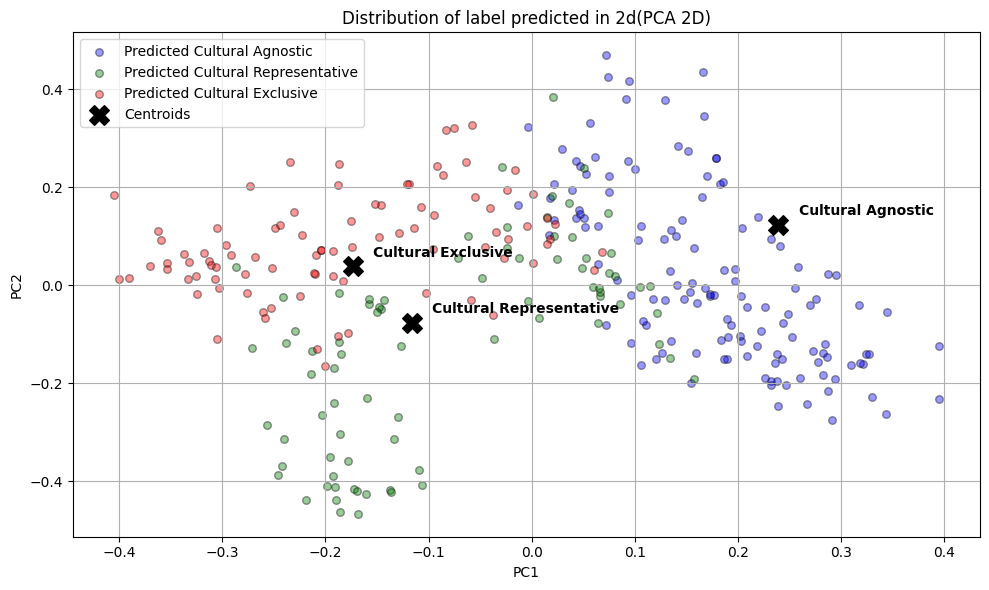

In [50]:
plot_graph_centroid_prediction(list_x_dev_weight=list_x_test_weight,centroids=centroids,Y_pred=Y_test_pred)